# sms ham & spam classification

## 1st we know how countvectorizer work


**Here we going to make a sample data**

In [1]:
# example text for model training
simple_train = ['call you tonight', 'Call me a cab', 'please call me.. please']

**import and instantiate CountVectorizer (with the default parameters)**

In [21]:
!pip install scikit-learn
!pip install pandas
!pip install seaborn
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.0/245.0 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 41.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.3 MB/s eta 0:00:00


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

#  instantiate CountVectorizer (vectorizer)
vect = CountVectorizer()

**When we fit CountVectorizer it will a vocabulary of word in a dict**

In [9]:
# 3. fit
# learn the 'vocabulary' of the training data (occurs in-place)
vect.fit(simple_train)

CountVectorizer()

In [11]:
# examine the fitted vocabulary
vect.get_feature_names_out()

array(['cab', 'call', 'me', 'please', 'tonight', 'you'], dtype=object)

**now we are going to use transform function after fitiong the data**

**It will convert vocabulary to number(sparse matrix)**

In [12]:
# 4. transform training data into a 'document-term matrix','sparse matrix'
simple_train_dtm = vect.transform(simple_train)
print(simple_train_dtm)

  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2


**Now we are going to convert sparse matrix to a dense matrix**

In [13]:
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]])

examine the sparse matrix contents
* left: coordinates of non-zero values
* right: values at that point

CountVectorizer() will output a sparse matrix

In [14]:
print('sparse matrix')
print(simple_train_dtm)

print('dense matrix')
print(simple_train_dtm.toarray())

sparse matrix
  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2
dense matrix
[[0 1 0 0 1 1]
 [1 1 1 0 0 0]
 [0 1 1 2 0 0]]


In [20]:
import pandas as pd

pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names_out())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


**By the above data frame you easily understand**

**How we convert text data in to number**
**you can see we have three row in the data frame 
bacause there are only three sentences in our simple data**

**here you can see all the vocabulary we get from the data, now become a featue**


# Now be going to work on original data 

In [23]:
#reading data
import warnings as wr
wr.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

sms=pd.read_csv("./spam.csv", encoding='latin-1')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [24]:
sms.shape

(5572, 5)

<Axes: >

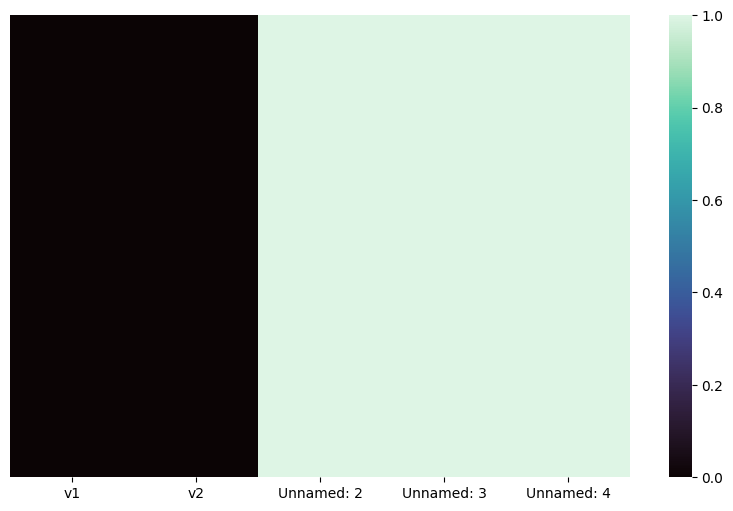

In [25]:
plt.figure(figsize=(10,6))
sns.heatmap(sms.isnull(),yticklabels=False,cbar=True,cmap='mako')

In [26]:
sms.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

Here we can say there are many NaN value in unnamed columns, so we are going to drop those frature

In [27]:
sms=sms.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"],axis=1)
sms.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Feature description
* v1=label(ham/spam) outcome to predict
* v2=sms

In [28]:
# examine the class distribution
sms.v1.value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='v1'>

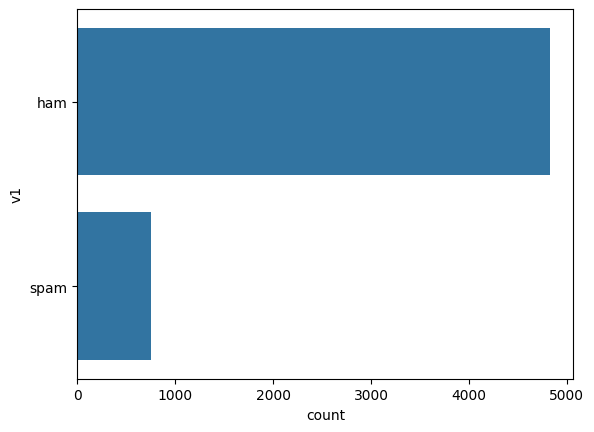

In [29]:
sns.countplot(sms["v1"])

In [30]:
# convert label to a numerical variable
sms['v1'] = sms.v1.map({'ham':0, 'spam':1})

In [31]:
sms.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


**Balance Data**

In [38]:
ham=sms[sms["v1"]==0]
spam=sms[sms["v1"]==1]

In [39]:
ham.shape,spam.shape

((4825, 2), (747, 2))

In [40]:
ham=ham.sample(spam.shape[0])
ham.shape

(747, 2)

In [59]:
data = pd.concat([ham, spam], ignore_index=True)
print("Shape :", data.shape)
data.head()

Shape : (1494, 2)


,v1,v2
0,0,"I can't speak, bcaz mobile have problem. I can..."
1,0,7 lor... Change 2 suntec... Wat time u coming?
2,0,"Well, I was about to give up cos they all said..."
3,0,"G says you never answer your texts, confirm/deny"
4,0,Da is good good player.why he is unsold.


<Axes: xlabel='v1', ylabel='count'>

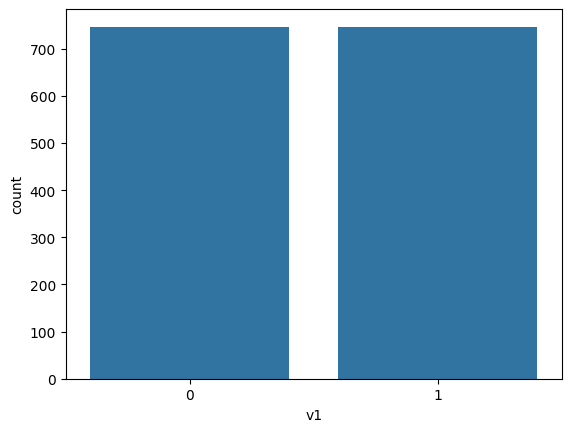

In [61]:
sns.countplot(x="v1", data=data)

* Now we can see data is balanced

**dividing data in X & Y**

In [62]:
X = data.v2
y = data.v1

# Model building

In [63]:
# split X and y into training and testing sets
# by default, it splits 75% training and 25% test
# random_state=1 for reproducibility

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1120,)
(374,)
(1120,)
(374,)


**calling CountVectorizer**

In [64]:
vect = CountVectorizer()

In [65]:
X_train_dtm = vect.fit_transform(X_train)

In [66]:
X_train_dtm

<1120x3993 sparse matrix of type '<class 'numpy.int64'>'
	with 19009 stored elements in Compressed Sparse Row format>

In [67]:
# 4. transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

# you can see that the number of columns, 7456, is the same as what we have learned above in X_train_dtm

<374x3993 sparse matrix of type '<class 'numpy.int64'>'
	with 5662 stored elements in Compressed Sparse Row format>

# MultinomialNB
**MultinomialNB is the one of the best algo for Text data**

In [68]:
# 1. import
from sklearn.naive_bayes import MultinomialNB

# 2. instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

In [70]:
# 3. train the model 

nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [71]:
# 4. make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [72]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.9652406417112299

**Here we got .96 score**

**printing the confusion matrix**
to compare actual and prediction

In [73]:

cf_matrix=metrics.confusion_matrix(y_test, y_pred_class)
cf_matrix

array([[171,   6],
       [  7, 190]])

<Axes: >

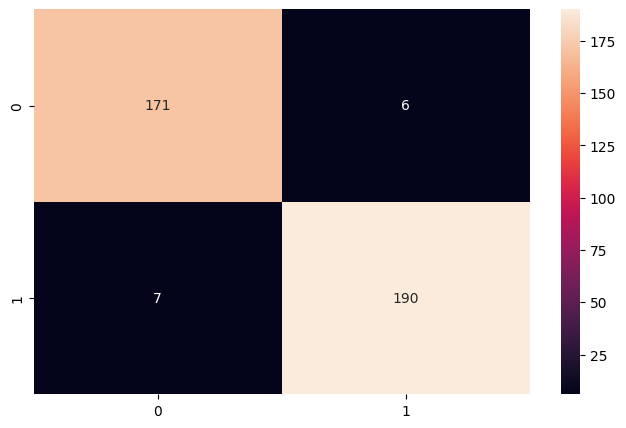

In [74]:
import matplotlib.pyplot as plt
#Ploting confusion matrix
plt.figure(figsize=(8,5))
sns.heatmap(cf_matrix, annot=True, fmt='d')

In [75]:
# print message text for the false positives (ham incorrectly classified as spam)

X_test[(y_pred_class==1) & (y_test==0)]

649             Surely result will offer:)
742                         No b4 Thursday
202                 Whens your radio show?
425               St andre, virgil's cream
650       I want to lick your pussy now...
431    U WILL SWITCH YOUR FONE ON DAMMIT!!
Name: v2, dtype: object

In [76]:
# print message text for the false negatives (spam incorrectly classified as ham)
X_test[(y_pred_class==0) & (y_test==1)]

1193                                                                          Sorry I missed your call let's talk when you have the time. I'm on 07090201529
1242                                                                                                                                           2/2 146tf150p
1200                LIFE has never been this much fun and great until you came in. You made it truly special for me. I won't forget you! enjoy @ one gbp/sms
748     FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
1151                 Do you ever notice that when you're driving, anyone going slower than you is an idiot and everyone driving faster than you is a maniac?
855                                                   Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?
952                                                       

In [77]:
# calculate AUC
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
metrics.roc_auc_score(y_test, y_pred_prob)

0.9871375720554074

# LogisticRegression

In [78]:
# 1. import
from sklearn.linear_model import LogisticRegression

# 2. instantiate a logistic regression model
logreg = LogisticRegression()

In [79]:
# 3. train the model using X_train_dtm
logreg.fit(X_train_dtm, y_train)

LogisticRegression()

In [80]:
# 4. make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [81]:
# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
y_pred_prob

array([1.71498067e-02, 3.27731530e-02, 9.95787688e-01, 9.96714220e-01,
       9.98346728e-01, 9.94801697e-01, 9.99139356e-01, 9.27852187e-01,
       9.99993603e-01, 9.99890966e-01, 9.99029646e-01, 2.27971662e-02,
       6.71347465e-02, 1.13813222e-02, 9.99894858e-01, 9.99874113e-01,
       9.99750336e-01, 9.84296901e-01, 9.65489651e-01, 9.48346637e-01,
       2.49487248e-01, 9.99895156e-01, 2.82327285e-02, 9.98442057e-01,
       2.03104767e-02, 9.81915038e-01, 9.90753762e-01, 9.86992262e-01,
       9.98050837e-01, 9.93226561e-01, 2.64013711e-02, 9.99826418e-01,
       8.28532734e-01, 9.95896863e-01, 9.85837029e-01, 8.23998335e-02,
       3.38150939e-01, 9.96108931e-01, 2.08929770e-02, 4.10024142e-02,
       2.06080385e-02, 9.99967281e-01, 2.64053086e-01, 9.98208134e-01,
       9.30637437e-01, 5.42038086e-01, 8.98038784e-01, 9.92380863e-01,
       9.99369800e-01, 1.33044111e-02, 1.61799705e-02, 7.25619974e-03,
       8.79223117e-01, 4.30804111e-02, 6.21938090e-01, 3.96666940e-03,
      

In [82]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.9572192513368984

In [83]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.987223608362729

In [84]:
# remove English stop words
vect1 = CountVectorizer(stop_words='english')

X_train_1 = vect1.fit_transform(X_train)

X_train_1


<1120x3774 sparse matrix of type '<class 'numpy.int64'>'
	with 12250 stored elements in Compressed Sparse Row format>

In [85]:
# include 1-grams and 2-grams

# how to differentiate between "Happy", "Not Happy", "Very Happy"
vect2 = CountVectorizer(ngram_range=(1, 2))

X_train_2 = vect2.fit_transform(X_train)

X_train_2

<1120x16202 sparse matrix of type '<class 'numpy.int64'>'
	with 38194 stored elements in Compressed Sparse Row format>

In [86]:
# ignore terms that appear in more than 50% of the documents
vect3 = CountVectorizer(max_df=0.5)

X_train_3 = vect3.fit_transform(X_train)

X_train_3

<1120x3993 sparse matrix of type '<class 'numpy.int64'>'
	with 19009 stored elements in Compressed Sparse Row format>

In [87]:
# only keep terms that appear in at least 2 documents
vect4 = CountVectorizer(min_df=2)

X_train_4 = vect4.fit_transform(X_train)

X_train_4

<1120x1725 sparse matrix of type '<class 'numpy.int64'>'
	with 16741 stored elements in Compressed Sparse Row format>

In [88]:
vect_combined= CountVectorizer(stop_words='english',ngram_range=(1, 2),min_df=2,max_df=0.5)

In [89]:
X_train_c = vect_combined.fit_transform(X_train)
X_test_c = vect_combined.transform(X_test)

X_train_c

<1120x3113 sparse matrix of type '<class 'numpy.int64'>'
	with 15014 stored elements in Compressed Sparse Row format>

In [90]:
# 1. import
from sklearn.naive_bayes import MultinomialNB

# 2. instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

nb.fit(X_train_c, y_train)

y_pred_class = nb.predict(X_test_c)

nb_cf_matrix=metrics.confusion_matrix(y_test, y_pred_class)

<Axes: >

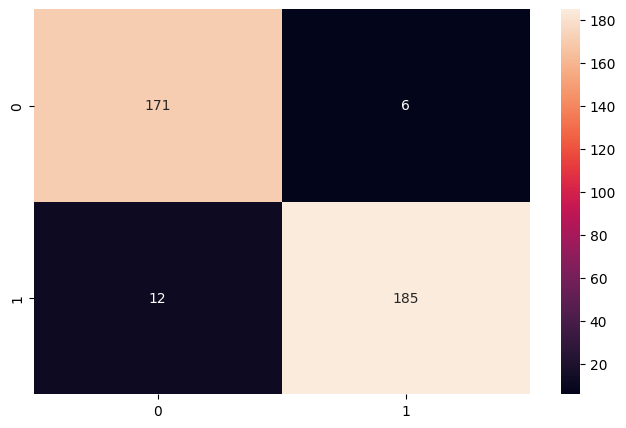

In [91]:
plt.figure(figsize=(8,5))
sns.heatmap(nb_cf_matrix, annot=True, fmt='d')